# Analyze the Yolov5 model performance and accuracy by OpenVINO POT API

This tutorial demonstrates step-by-step instructions to perform the model quantization by OpenVINO [Post-Training Optimization Tool (POT)](https://docs.openvino.ai/latest/pot_introduction.html), and to compare model accuracy between FP32 precision and quantized INT8 precision and to show a demo of running model inference based Ultralytics sample with OpenVINO 2022.1 backend.

First, follow [Ultralytics Yolov5](https://github.com/ultralytics/yolov5) project to get Yolov5-m model with OpenVINO Intermediate Representation (IR) formats. Then use OpenVINO [Post-Training Optimization Tool (POT)](https://docs.openvino.ai/latest/pot_introduction.html) API to quantize model based on Ultralytics provided Non-Max Suppression (NMS) processing.

OpenVINO POT provides two usages:
1. Use API to override the model DataLoader class with custom image/annotation loading and preprocessing; Identify your own class which is inherited from Metric for inference result postprocessing and accuracy calculation part.
2. Use POT command tool with [Accuracy Checker](https://github.com/openvinotoolkit/open_model_zoo/blob/master/tools/accuracy_checker/README.md) provided adapters, pre/postprocessing, metric by configuration file; this normally recommend to use for OpenVINO [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo) model by omz_quantizer tool.

Ultralytics provided data pre/post-processing functions are different from Accuracy Checker provided configuration for Yolov4 version. Thus, for this case, use POT API which customized DataLoader and Metric can make sure the minimum accuracy difference between FP32 and INT8 model during the quantization. 

Another quantization method with POT command line tool has been introduced in [Intel Resource & Documentation Center](https://cdrdv2.intel.com/v1/dl/getContent/644715). It cut off the model post-processing part and replace with Accuracy Checker provided postprocess of Yolov4 to check accuracy and quantize. The Accuracy result might be different from Ultralytics original postprocessing results.

## Preparation

### Get Ultralytics Yolov5 model

In [1]:
%%sh
git clone https://github.com/ultralytics/yolov5.git
cd yolov5
git checkout v6.1
wget https://github.com/ultralytics/yolov5/releases/download/v6.1/yolov5m.pt -P yolov5m
python export.py --weights yolov5m/yolov5m.pt --imgsz 640 --batch-size 1 --include openvino

Cloning into 'yolov5'...
Note: switching to 'v6.1'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 3752807 YOLOv5 v6.1 release (#6739)
--2022-07-05 00:27:39--  https://github.com/ultralytics/yolov5/releases/download/v6.1/yolov5m.pt
Resolving child-prc.sh.intel.com (child-prc.sh.intel.com)... 10.239.120.56
Connecting to child-prc.sh.intel.com (child-prc.sh.intel.com)|10.239.120.56|:913... connected.
Proxy request sent, awaiting response... 302 Found
Location: https://objects.githubusercontent.com/github-product

### Import Modules of POT

In [2]:
import argparse
import os
import sys
#import inspect
from pathlib import Path
import numpy as np
from addict import Dict
import matplotlib.pyplot as plt


import torch

#print(os.path.dirname(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))))
sys.path.append("./yolov5/")

from yolov5.utils.datasets import create_dataloader
from yolov5.utils.general import check_dataset, non_max_suppression, scale_coords, xywh2xyxy, box_iou, print_args, check_yaml,increment_path
from yolov5.utils.metrics import ap_per_class
from yolov5.val import process_batch

from openvino.tools.pot.api import Metric, DataLoader
from openvino.tools.pot.engines.ie_engine import IEEngine
from openvino.tools.pot.graph import load_model, save_model
from openvino.tools.pot.graph.model_utils import compress_model_weights
from openvino.tools.pot.pipeline.initializer import create_pipeline
from openvino.tools.pot.utils.logger import init_logger, get_logger

## Model Quantization by POT API
### Create Yolov5 DataLoader class

Create a class for Yolov5 dataset and annotation loading which inherit from POT API class DataLoader. Ultralytics Yolov5 training progress require image data nomolize from [0,225] 8 bits integer to [0.0,1.0] 32 bits Float.

In [3]:
class YOLOv5DataLoader(DataLoader):

    def __init__(self, config):
        if not isinstance(config, Dict):
            config = Dict(config)
        super().__init__(config)

        self._data_source = config.data_source
        self._imgsz = config.imgsz
        self._batch_size = 1
        self._stride = 32
        self._single_cls = config.single_cls
        self._pad = 0.5
        self._rect = False
        self._workers = 1
        self._data_loader = self._init_dataloader()
        self._data_iter = iter(self._data_loader)

    def __len__(self):
        return len(self._data_loader.dataset)

    def _init_dataloader(self):
        # Load image with 640x640
        dataloader = create_dataloader(self._data_source['val'], imgsz=self._imgsz, batch_size=self._batch_size, stride=self._stride,
                                       single_cls=self._single_cls, pad=self._pad, rect=self._rect, workers=self._workers)[0]
        # Load image with original size
        #dataloader = create_dataloader(self._data_source['val'], imgsz=self._imgsz, batch_size=self._batch_size, stride=self._stride,
        #                               single_cls=self._single_cls, pad=self._pad, rect=False, workers=self._workers)[0]


        return dataloader

    def __getitem__(self, item):
        try:
            batch_data = next(self._data_iter)
        except StopIteration:
            self._data_iter = iter(self._data_loader)
            batch_data = next(self._data_iter)

        im, target, path, shape = batch_data

        im = im.float()  # uint8 to fp32
        im /= 255  # 0 - 255 to 0.0 - 1.0
        nb, _, height, width = im.shape  # batch size, channels, height, width
        img = im.cpu().detach().numpy()
        target = target.cpu().detach().numpy()
        #print("target: ", target)

        annotation = dict()
        annotation['image_path'] = path
        annotation['target'] = target
        annotation['batch_size'] = nb
        annotation['shape'] = shape
        annotation['width'] = width
        annotation['height'] = height
        annotation['img'] = img

        return (item, annotation), img

### Create Yolov5 Metric class

Create a class to measure the model accuracy by Mean Average Precision (mAP) with COCO dataset predicted result and annotation value. Here both use AP@0.5 and AP@0.5:0.95 as measurement standard.This class should be inherited from POT API Metric class.

The COCOMetric.update() function contains post-processing with Non-Max Suppression to sort boxes by score and select the box with highest score.

In [4]:
class COCOMetric(Metric):

    # Required methods
    def __init__(self, config):
        super().__init__()
        self._metric_dict = {"AP@0.5": [], "AP@0.5:0.95": []}
        self._names = (*self._metric_dict,)
        self._stats = []
        self._last_stats = []
        self._conf_thres = config.conf_thres
        self._iou_thres = config.iou_thres
        self._single_cls = config.single_cls
        self._nc = config.nc
        self._class_names = {i:name for i,name in enumerate(config.names)}
        self._device = config.device

    @property
    def value(self):
        """ Returns accuracy metric value for the last model output.
        Possible format: {metric_name: [metric_values_per_image]}
        """
        mp, mr, map50, map = self._process_stats(self._last_stats)
        #print("[precision]: {}, [recall]: {}, [AP@0.5]: {}, [AP@0.5:0.95]: {}".format(mp, mr, map50, map))

        return {self._names[0]: [map50], self._names[1]: [map]}

    @property
    def avg_value(self):
        """ Returns accuracy metric value for all model outputs.
        Possible format: {metric_name: metric_value}
        """
        mp, mr, map50, map = self._process_stats(self._stats)
        #print("[precision]: {}, [recall]: {}, [AP@0.5]: {}, [AP@0.5:0.95]: {}".format(mp, mr, map50, map))

        return {self._names[0]: map50, self._names[1]: map}

    def _process_stats(self, stats):
        mp, mr, map50, map = 0.0, 0.0, 0.0, 0.0
        stats = [np.concatenate(x, 0) for x in zip(*stats)]  # to numpy
        if len(stats) and stats[0].any():
            tp, fp, p, r, f1, ap, ap_class = ap_per_class(*stats, plot=False, save_dir=None, names=self._class_names)
            ap50, ap = ap[:, 0], ap.mean(1)  # AP@0.5, AP@0.5:0.95
            mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()
            nt = np.bincount(stats[3].astype(np.int64), minlength=self._nc)  # number of targets per class
        else:
            nt = torch.zeros(1)

        return mp, mr, map50, map

    def update(self, output, target):
        """ Calculates and updates metric value
        :param output: model output
        :param target: annotations
        """

        annotation = target[0]["target"]
        width = target[0]["width"]
        height = target[0]["height"]
        nb = target[0]["batch_size"]
        shapes = target[0]["shape"]
        paths = target[0]["image_path"]
        im = target[0]["img"]

        iouv = torch.linspace(0.5, 0.95, 10).to(self._device)  # iou vector for mAP@0.5:0.95
        niou = iouv.numel()
        seen = 0
        stats = []
        # NMS
        annotation = torch.Tensor(annotation)
        annotation[:, 2:] *= torch.Tensor([width, height, width, height]).to(self._device)  # to pixels
        lb = []
        out = output[0]
        out = torch.Tensor(out).to(self._device)
        out = non_max_suppression(out, self._conf_thres, self._iou_thres, labels=lb,
                                  multi_label=True, agnostic=self._single_cls)
        # Metrics
        for si, pred in enumerate(out):
            labels = annotation[annotation[:, 0] == si, 1:]
            nl = len(labels)
            tcls = labels[:, 0].tolist() if nl else []  # target class
            path, shape = Path(paths[si]), shapes[si][0]
            seen += 1

            if len(pred) == 0:
                if nl:
                    stats.append((torch.zeros(0, niou, dtype=torch.bool), torch.Tensor(), torch.Tensor(), tcls))
                continue

            # Predictions
            if self._single_cls:
                pred[:, 5] = 0
            predn = pred.clone()
            scale_coords(im[si].shape[1:], predn[:, :4], shape, shapes[si][1])  # native-space pred

            # Evaluate
            if nl:
                tbox = xywh2xyxy(labels[:, 1:5])  # target boxes
                scale_coords(im[si].shape[1:], tbox, shape, shapes[si][1])  # native-space labels
                labelsn = torch.cat((labels[:, 0:1], tbox), 1)  # native-space labels
                correct = process_batch(predn, labelsn, iouv)
            else:
                correct = torch.zeros(pred.shape[0], niou, dtype=torch.bool)
            stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))  # (correct, conf, pcls, tcls)
            self._stats.append((correct.cpu(), pred[:, 4].cpu(), pred[:, 5].cpu(), tcls))
        self._last_stats = stats

    def reset(self):
        """ Resets metric """
        self._metric_dict = {"AP@0.5": [], "AP@0.5:0.95": []}
        self._last_stats = []
        self._stats = []

    def get_attributes(self):
        """
        Returns a dictionary of metric attributes {metric_name: {attribute_name: value}}.
        Required attributes: 'direction': 'higher-better' or 'higher-worse'
                                                 'type': metric type
        """
        return {self._names[0]: {'direction': 'higher-better',
                                 'type': 'AP@0.5'},
                self._names[1]: {'direction': 'higher-better',
                                 'type': 'AP@0.5:0.95'}}

### Set POT configration

Create a function to set configuration of model, engine, dataset, metric and algorithms, which used by POT class and functions.

In this case, use "DefaultQuantization" for best performance. If change the quantization algorithm to "AccuracyAwear", the quantization progress allows keeping accuracy at a predefined range at the cost of performance improvement in case when Default Quantization cannot guarantee it.

In [5]:
def get_config():
    config  = Dict()
    data_yaml = check_yaml("./yolov5/data/coco128.yaml")
    data = check_dataset(data_yaml)

    model_config = Dict({
        "model_name": os.path.splitext(os.path.basename("./yolov5/yolov5m/yolov5m_openvino_model/yolov5m.xml"))[0],
        "model": "./yolov5/yolov5m/yolov5m_openvino_model/yolov5m.xml",
        "weights": os.path.splitext("./yolov5/yolov5m/yolov5m_openvino_model/yolov5m.xml")[0] + ".bin"
    })

    engine_config = Dict({
        "device": "CPU",
        "stat_requests_number": 30,
        "eval_requests_number": 30
    })

    dataset_config = Dict({
        "data_source": data,
        "imgsz": 640,
        "single_cls": True,
    })

    metric_config = Dict({
        "conf_thres": 0.001,
        "iou_thres": 0.65,
        "single_cls": True,
        "nc": 1 , #if opt.single_cls else int(data['nc']),
        "names": data["names"],
        "device": "cpu"
    })

    algorithms = [
        {
            "name": "DefaultQuantization", # or AccuracyAwear
            "params": {
                    "target_device": "CPU",
                    "preset": "performance",
                    "stat_subset_size": 300,
                    "model_type": "transformer"
            }
        }
    ]

    config["model"] = model_config
    config["engine"] = engine_config
    config["dataset"] = dataset_config
    config["metric"] = metric_config
    config["algorithms"] = algorithms
    
    return config

### Run Quantization Pipeline and Accuracy Verification

Use 9 steps to quantize model by POT common function progress, the optimized model intermediate representation with collected min-max values will be saved. 

In [6]:
config = get_config() #Download dataset and set config
init_logger(level='INFO')
logger = get_logger(__name__)
save_dir = increment_path(Path("./yolov5/yolov5m/yolov5m_openvino_model/"), exist_ok=True)  # increment run
save_dir.mkdir(parents=True, exist_ok=True)  # make dir

# Step 1: Load the model.
model = load_model(config["model"])

# Step 2: Initialize the data loader.
data_loader = YOLOv5DataLoader(config["dataset"])

# Step 3 (Optional. Required for AccuracyAwareQuantization): Initialize the metric.
metric = COCOMetric(config["metric"])

# Step 4: Initialize the engine for metric calculation and statistics collection.
engine = IEEngine(config=config["engine"],
                    data_loader=data_loader, metric=metric)

# Step 5: Create a pipeline of compression algorithms.
pipeline = create_pipeline(config["algorithms"], engine)

metric_results = None

#Check the FP32 model accuracy firstly.
metric_results_fp32 = pipeline.evaluate(model)

logger.info("FP32 model metric_results: {}".format(metric_results_fp32))

# Step 6: Execute the pipeline to calculate Min-Max value
compressed_model = pipeline.run(model)

# Step 7 (Optional):  Compress model weights to quantized precision
#                     in order to reduce the size of final .bin file.
compress_model_weights(compressed_model)

# Step 8: Save the compressed model to the desired path.
save_model(compressed_model, os.path.join(os.path.curdir, os.path.join(save_dir,"optimized")), config["model"]["model_name"])

# Step 9 (Optional): Evaluate the compressed model. Print the results.
metric_results_i8 = pipeline.evaluate(compressed_model)

logger.info("Save quantized model in {}".format(save_dir))
logger.info("Quantized INT8 model metric_results: {}".format(metric_results_i8))

  0%|          | 0.00/6.66M [00:00<?, ?B/s]

Scanning '/home/fiona/Documents/projects/openvino_notebooks/notebooks/306-pytorch-object-detection-accuracy-check-and-quantization/datasets/coco128/labels/train2017' images and labels...128 found, 0 missing, 2 empty, 0 corrupt: 100%|██████████| 128/128 [00:00<00:00, 46079.38it/s]


INFO:openvino.tools.pot.pipeline.pipeline:Evaluation of generated model
INFO:openvino.tools.pot.engines.ie_engine:Start inference of 128 images
INFO:openvino.tools.pot.engines.ie_engine:13/128 batches are processed in 2.03s
INFO:openvino.tools.pot.engines.ie_engine:26/128 batches are processed in 3.88s
INFO:openvino.tools.pot.engines.ie_engine:39/128 batches are processed in 5.53s
INFO:openvino.tools.pot.engines.ie_engine:52/128 batches are processed in 7.27s
INFO:openvino.tools.pot.engines.ie_engine:65/128 batches are processed in 9.17s
INFO:openvino.tools.pot.engines.ie_engine:78/128 batches are processed in 10.95s
INFO:openvino.tools.pot.engines.ie_engine:91/128 batches are processed in 12.70s
INFO:openvino.tools.pot.engines.ie_engine:104/128 batches are processed in 14.52s
INFO:openvino.tools.pot.engines.ie_engine:117/128 batches are processed in 16.34s
INFO:openvino.tools.pot.engines.ie_engine:Inference finished
INFO:__main__:FP32 model metric_results: {'AP@0.5': 0.762815528701737

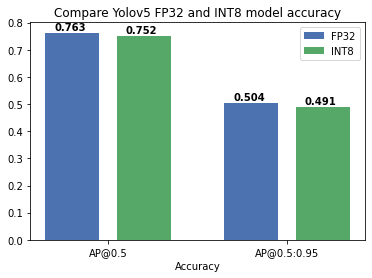

In [7]:
%matplotlib inline
plt.style.use('seaborn-deep')
fp32_acc=np.array(list(metric_results_fp32.values()))
int8_acc=np.array(list(metric_results_i8.values()))
x_data=("AP@0.5","AP@0.5:0.95")
x_axis=np.arange(len(x_data))
fig = plt.figure()
fig.patch.set_facecolor('#FFFFFF')
fig.patch.set_alpha(0.7)
ax = fig.add_subplot(111)
plt.bar(x_axis-0.2,fp32_acc,0.3,label='FP32')
for i in range(0, len(x_axis)):
    plt.text(i-0.3, round(fp32_acc[i],3)+0.01, str(round(fp32_acc[i],3)),fontweight="bold")
plt.bar(x_axis+0.2,int8_acc,0.3,label='INT8')
for i in range(0, len(x_axis)):
    plt.text(i+0.1, round(int8_acc[i],3)+0.01, str(round(int8_acc[i],3)),fontweight="bold")
plt.xticks(x_axis, x_data)
plt.xlabel("Accuracy")
plt.title("Compare Yolov5 FP32 and INT8 model accuracy")

plt.legend()
plt.show()

## Inference Demo Performance Comparison

This part shows how to use Ultralytics model detection program ["detect.py"](https://github.com/ultralytics/yolov5) to run sync inference with OpenVINO python API for 2 image.

In [8]:
%%sh
cd yolov5
python detect.py --weights ./yolov5m/yolov5m_openvino_model/optimized/yolov5m.xml

detect: weights=['./yolov5m/yolov5m_openvino_model/optimized/yolov5m.xml'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-0-g3752807 torch 1.7.1+cpu CPU

Loading yolov5m/yolov5m_openvino_model/optimized/yolov5m.xml for OpenVINO inference...
image 1/2 /home/fiona/Documents/projects/openvino_notebooks/notebooks/306-pytorch-object-detection-accuracy-check-and-quantization/yolov5/data/images/bus.jpg: 640x640 4 persons, 1 bus, Done. (0.071s)
image 2/2 /home/fiona/Documents/projects/openvino_notebooks/notebooks/306-pytorch-object-detection-accuracy-check-and-quantization/yolov5/data/images/zidane.jpg: 640x640 2 persons, 2 ties, D

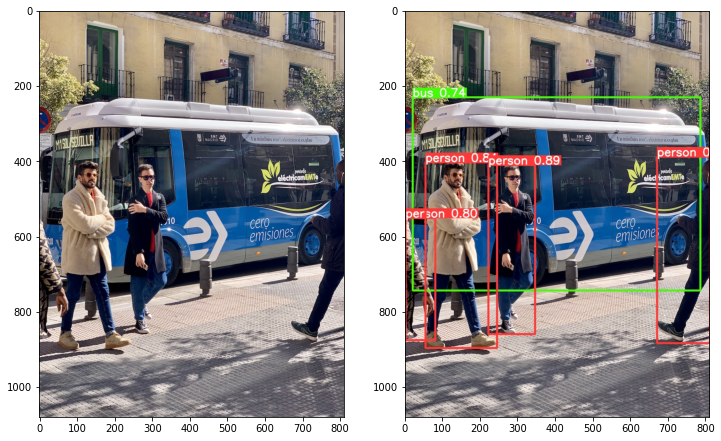

In [9]:
import matplotlib.image as mpimg
%matplotlib inline
fig2 = plt.figure(figsize=(12, 9))
fig2.patch.set_facecolor('#FFFFFF')
fig2.patch.set_alpha(0.7)
axarr1 = fig2.add_subplot(121)
axarr2 = fig2.add_subplot(122)
ori = mpimg.imread('./yolov5/data/images/bus.jpg')
result = mpimg.imread('./yolov5/runs/detect/exp/bus.jpg')
axarr1.imshow(ori)
axarr2.imshow(result)

## References

* [Ultralytics Yolov5](https://github.com/ultralytics/yolov5)
* [OpenVINO Post-training Optimization Tool](https://docs.openvino.ai/latest/pot_introduction.html)
* [OpenVINO Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo)
* [Accuracy Checker](https://github.com/openvinotoolkit/open_model_zoo/blob/master/tools/accuracy_checker/README.md)
